# Spot-checking inicial: Árvore de Decisão

As árvores de decisão são conhecidas por possuírem um baixo viés, ao mesmo tempo em que apresentam alta variância.
Isto é, o método é capaz de modelar fronteiras de decisão bastante complexas, o que, por um lado, é positivo, mas torna o algoritmo bastante suscetível a ruído ou a padrões nos dados de treino que não generalizam para instâncias de teste.
Por isso, técnicas de poda são fundamentais para o uso efetivo do modelo em dados novos.

Nessa atividade, iremos analisar como a estrutura e as predições da árvore de decisão são afetadas por pequenas variações no conjunto de treino. Além disso, veremos duas técnicas de poda que podem ser usadas para controlar a complexidade do modelo.

## Carregamento dos Dados

### Obtenção e análise dos dados
O código abaixo carrega o dataset utilizando as funções do scikit-learn e mostra algumas informações básicas sobre os dados

In [1]:
import pandas as pd

In [2]:
df_sinan_processed = pd.read_csv("../data/processed/processed-full-numeric.csv")

In [3]:
# Matriz de atributos
X = df_sinan_processed.drop("severity", axis=1)

# Vetor alvo
y = df_sinan_processed["severity"]

feature_names = X.columns.tolist()
target_names = ["low_risk", "alarm", "severe"]

# Mapeamento dos rótulos alvo para inteiros (por conveniência)
target_mapping = {name: idx for idx, name in enumerate(target_names)}
y = y.map(target_mapping)

In [4]:
from collections import Counter 

# Contagem do número de exemplos em cada classe
class_counts = Counter(y)
for target_class, count in class_counts.items():
    print(f"Número de exemplos na classe '{target_class}' ({target_names[target_class]}): {count}")

Número de exemplos na classe '0' (low_risk): 420845
Número de exemplos na classe '1' (alarm): 318190
Número de exemplos na classe '2' (severe): 31363


## Variância nas Árvores de Decisão


### Analisando a Estrutura das Árvores de Decisão


Como estudado em aula, a árvore de decisão é conhecida por ser um classificador com alta variância. Isso possui consequências na estrutura das árvores treinadas.

O código abaixo treina várias árvores de decisão com diferentes conjuntos de treino obtidos através do método holdout.


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def get_root_node(dt, feature_names):
    feature_idx = dt.tree_.feature[0]
    return feature_names[feature_idx]

n_repeats = 5
root_nodes = []

# Variando o seed do holdout, geramos diferentes conjuntos de treino/teste
for split_random_state in range(0, n_repeats):
  # Holdout com 20% de teste
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=split_random_state)

  # Treinamento da árvore de decisão
  dt = RandomForestClassifier(random_state=0)
  dt.fit(X_train, y_train)

  # Obtemos o atributo usado na raiz e o salvamos na lista
  root_node = get_root_node(dt, feature_names)
  root_nodes.append(root_node)

root_nodes

KeyboardInterrupt: 

### Analisando a Acurácia das Árvores de Decisão

A propriedade de variância também implica em efeitos na variabilidade da performance dos modelos.
Podemos usar a acurácia como medida de performance, o que pode ser feito também através do scikit-learn. Posteriormente estudaremos outras métricas de desempenho que são mais indicadas para problemas em que o número de instâncias por classe é desbalanceado, como é o caso deste conjunto de dados.

In [ ]:
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

dt = RandomForestClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia nos dados de teste: %.3f" % accuracy)

Acurácia nos dados de teste: 0.970


O código abaixo executa repetidas vezes o treinamento das árvores de decisão, da mesma forma que no item *Analisando a Estrutura das Árvores de Decisão*.

**Atenção: Não mude os valores que estão sendo passados para os parâmetros random_state para garantir a reprodutibilidade do código**.


In [ ]:
import numpy as np

accuracies = []

for split_random_state in range(0, n_repeats):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=split_random_state)

  dt = RandomForestClassifier(random_state=0)
  
  dt.fit(X_train, y_train)

  # Avaliação da acurácia nos dados de teste
  y_pred = dt.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  accuracies.append(accuracy)

# Cálculo das estatísticas descritivas
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
max_accuracy = np.max(accuracies)
min_accuracy = np.min(accuracies)

print(f"Acurácia média: {mean_accuracy:.3f}")
print(f"Desvio padrão: {std_accuracy:.3f}")
print(f"Acurácia máxima: {max_accuracy:.3f}")
print(f"Acurácia mínima: {min_accuracy:.3f}")


Acurácia média: 0.970
Desvio padrão: 0.000
Acurácia máxima: 0.970
Acurácia mínima: 0.970


## Observando o Efeito da Poda

As árvores de decisão treinadas nos itens anteriores não possuíam nenhuma forma de poda. No entanto, é possível utilizar técnicas de poda através do scikit-learn. Como consequência, elas podem ter uma complexidade além do que é necessário na modelagem do problema.



### Exemplo de Pré-poda: profundidade máxima da árvore
Podemos especificar a profundidade máxima da árvore utilizando o hiperparâmetro max_depth. Veja como exemplo o código abaixo.

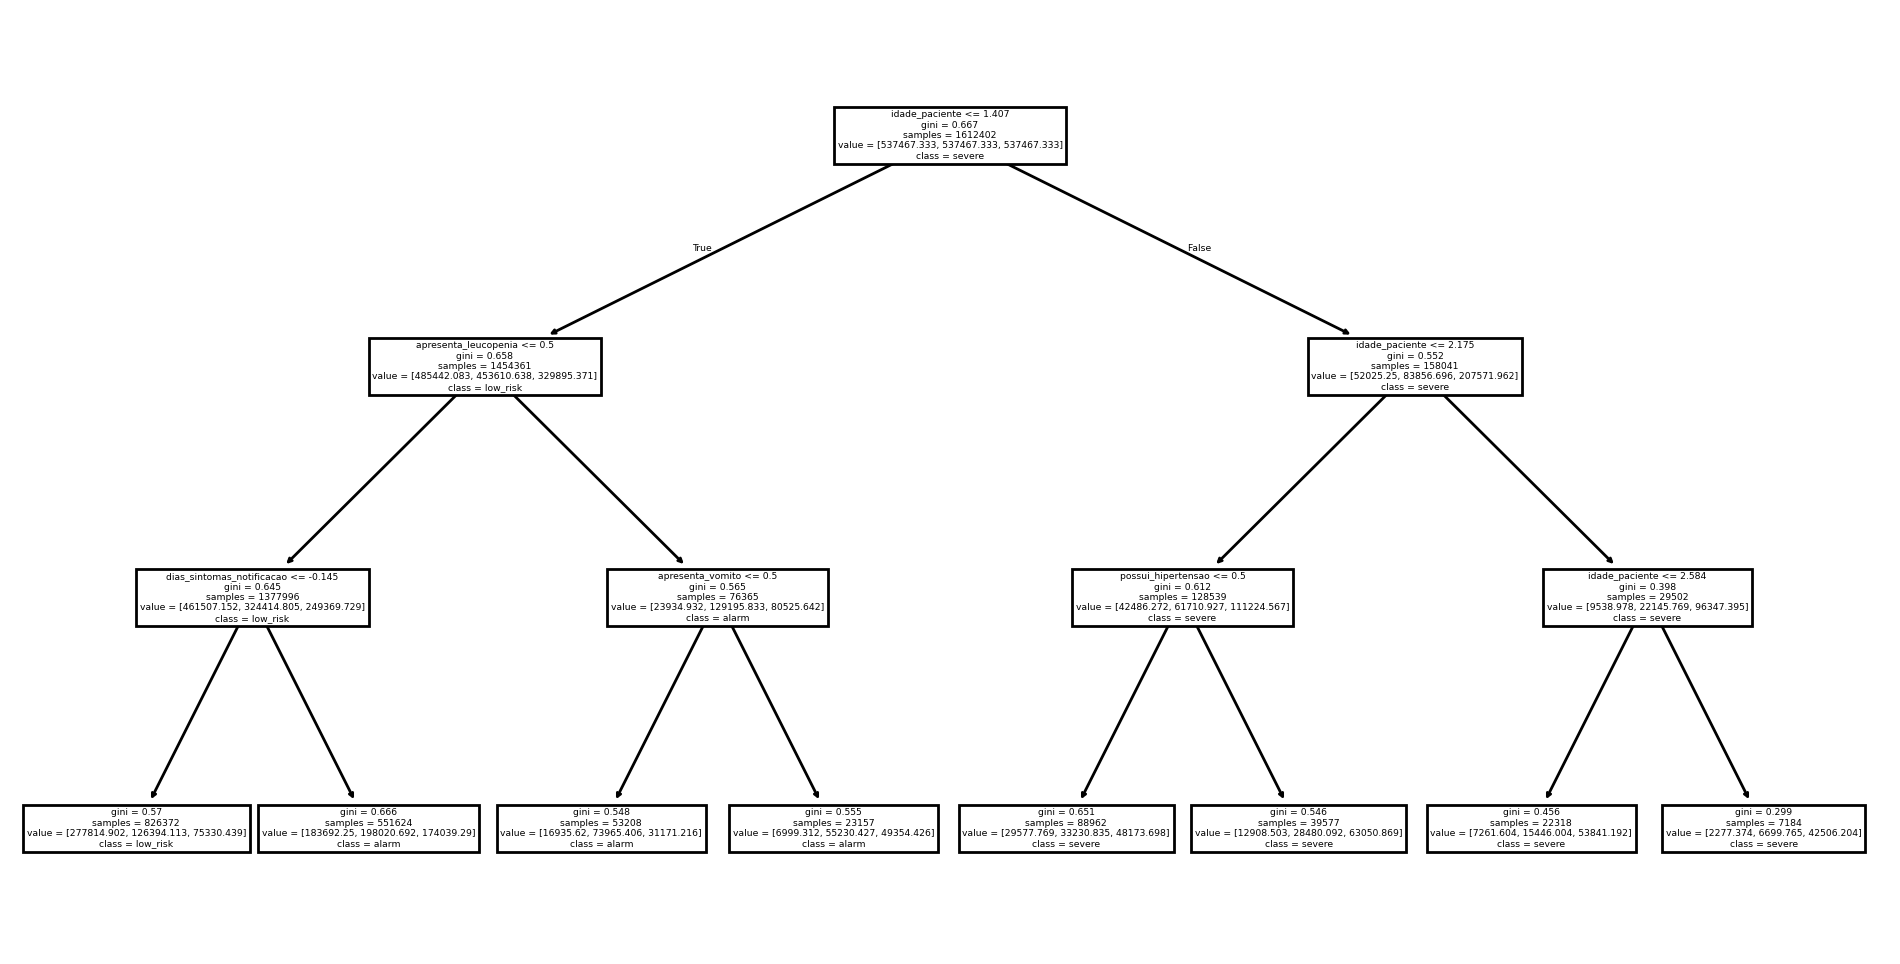

In [ ]:
import matplotlib.pyplot as plt

dt = RandomForestClassifier(max_depth=3, class_weight='balanced')
dt.fit(X, y)

from sklearn.ensemble import plot_tree
plt.figure(figsize=(12,6), dpi=200)
_ = plot_tree(dt, feature_names=feature_names, class_names=target_names)

O código abaixo gera árvores de decisão com diferentes profundidades máximas e as avalia em termos de acurácia.
Observe que todas as árvores são treinadas e avaliadas com os mesmos conjuntos de treino, validação e teste, visto que especificamos o parâmetro $random\_state = 42$.
Com base nesse código, e possíveis modificações que você faça a ele, responda à Questão  4 do questionário.

**Não mude o valor que está sendo passado em random_state**.


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Definindo as proporções de treino, validação e teste.
train_ratio = 0.70
test_ratio = 0.15
validation_ratio = 0.15

# Fazendo a primeira divisão, para separar um conjunto de teste dos demais.
# Assuma X_temp e y_temp para os dados de treinamento+validação e X_test e y_test para os de teste
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42, stratify=y)

# Fazendo a segunda divisão, para gerar o conjunto de treino e validação a partir
# do conjunto de 'treinamento' da divisão anterior
# Assuma X_train e y_train para os dados de treinamento e X_valid e y_valid para os de teste
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=validation_ratio/(train_ratio+test_ratio), random_state=42, stratify=y_temp)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(539278, 42)
(115560, 42)
(115560, 42)


## Amostragem de Dados

### Amostragem com SMOTE (Sem Undersampling)
Inicialmente, analisamos o desempenho do modelo ao treiná-lo com os dados amostrados utilizando apenas oversampling (algoritmo SMOTE). Nessa etapa, utilizamos o SMOTE para aumentar o número de instância nas classes minoritárias ('alarm' e 'severe') de modo que estas fiquem com o mesmo número de instâncias da classe majoritária ('low_risk').

In [39]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Distribuição original do treino:", Counter(y_train))

smote = SMOTE(random_state=42)

# Aplique o SMOTE apenas nos dados de treino
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Distribuição do treino após SMOTE:", Counter(y_train_resampled))

Distribuição original do treino: Counter({0: 294591, 1: 222732, 2: 21955})
Distribuição do treino após SMOTE: Counter({1: 294591, 0: 294591, 2: 294591})


In [16]:
from sklearn.metrics import f1_score

max_depths = [3, 5, 8, 10, 15, 20, 30]
f1_scores_valid = []
f1_scores_train = []

for depth in max_depths:
    dt = RandomForestClassifier(max_depth=depth, class_weight='balanced', random_state=0)
    dt.fit(X_train_resampled, y_train_resampled)

    y_pred = dt.predict(X_valid)

    f1_valid = f1_score(y_valid, y_pred, average='macro', zero_division=0)
    f1_scores_valid.append(f1_valid)

    y_pred_train = dt.predict(X_train)
    f1_train = f1_score(y_train, y_pred_train, average='macro', zero_division=0)
    f1_scores_train.append(f1_train)

    print(f"Max Depth: {depth}, F1-Score Validação: {f1_valid:.3f}, F1-Score Treino: {f1_train:.3f}")

KeyboardInterrupt: 

In [ ]:
f1_scores_valid

[0.2036263623888188,
 0.20840822408557047,
 0.2121053133065013,
 0.25633841409742847,
 0.2580747287524296,
 0.28895427325177764,
 0.28886457569837254,
 0.3066823630833808,
 0.3053582061211778,
 0.3166866210333818,
 0.32610863453756905,
 0.3338103790475364,
 0.33661772494213343,
 0.3280458660802004,
 0.34781585030421897,
 0.33745753966578174,
 0.34051381750658943,
 0.33986560151617895,
 0.3415485385829688,
 0.3399948716332432,
 0.3576984188103239]

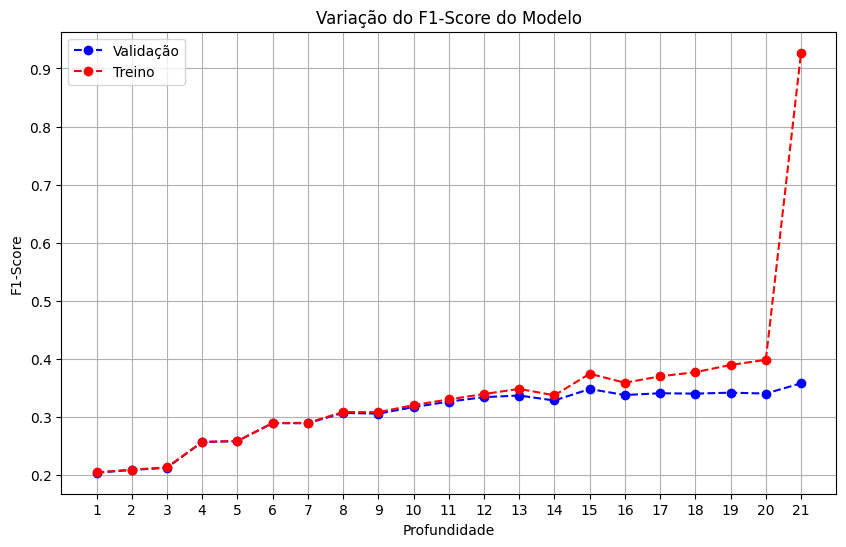

In [ ]:
max_depths_labels = [str(d) if d is not None else '-' for d in max_depths]

plt.figure(figsize=(10,6))
plt.plot(max_depths_labels, f1_scores_valid, marker='o', linestyle='--', color='b', label='Validação')
plt.plot(max_depths_labels, f1_scores_train, marker='o', linestyle='--', color='r', label='Treino')
plt.title('Variação do F1-Score do Modelo')
plt.xlabel('Profundidade')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)
plt.show()

Para avaliarmos o desempenho do modelo otimizado em novos dados, devemos repetir o treinamento selecionando o melhor valor de hiperparâmetro(s) com base no gráfico anterior, e fazer a avaliação nos dados de teste.
Para melhorar a capacidade de estimar o desempenho do modelo, podemos treinar com os dados de treinamento e validação, tendo em vista que ambos são independentes do conjunto de teste (dados nunca vistos).


In [7]:
# from imblearn.over_sampling import SMOTE
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import f1_score
# import numpy as np

# X_train2 = np.concatenate((X_train, X_valid), axis=0)
# y_train2 = np.concatenate((y_train, y_valid), axis=0)

# smote_final = SMOTE(random_state=42)

# X_train_final, y_train_final = smote_final.fit_resample(X_train2, y_train2)

# Treina e avalia o modelo com valor otimizado de max_depth
# best_max_depth = max_depths[np.argmax(f1_scores_valid)]
# print(f"Best max_depth: {best_max_depth}")
best_max_depth = 50

dt = RandomForestClassifier(max_depth=best_max_depth, class_weight='balanced', random_state=0)
dt.fit(X_train_final, y_train_final)

y_pred = dt.predict(X_test)

# acc_test = accuracy_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred, average='macro', zero_division=0)
# print(f"Acurácia (Dados de Teste): {acc_test:.3f}")
print(f"F1-Macro (Dados de Teste): {f1_test:.3f}")

/home/gabriel/Documents/UFRGS/2025-2/ML/TF/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


F1-Macro (Dados de Teste): 0.930


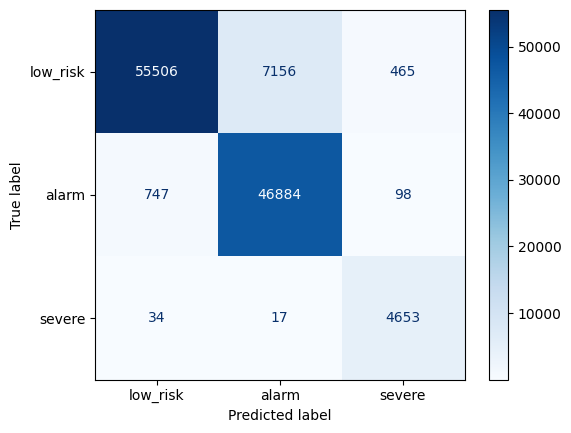

In [8]:
# Plota a matriz de confusão
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=target_names, cmap=plt.cm.Blues)

### Amostragem com Undersampling Aleatório e SMOTE
SMOTE (sozinho) não é a ferramenta ideal para trabalhar com o nosso dataset. A matriz de confusão deixa isso bastante evidente, visto que o número de falsos negativos em instâncias da classe "severe", o qual é um valor que **deve** ser minimizado, é bastante alto (mais alto que o número de verdadeiros positivos). Isso se deve ao fato de o número de exemplos dessa classe ser pequeno demais, em relação ao número total de exemplos do dataset, para aplicar apenas o SMOTE padrão.

A seguir, testamos uma técnica que combina SMOTE (oversampling) com undersampling.

In [10]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

class_counts = Counter(y_train)

print("Distribuição original do treino:", class_counts)

# Step 1: Define the undersampling strategy
under_sampler = RandomUnderSampler(
    sampling_strategy={0: class_counts[1]},
    random_state=42
)

# Step 2: Define the oversampling strategy
over_sampler = SMOTE(
    sampling_strategy={2: class_counts[1] // 2},
    random_state=42
)

# Step 3: Create the pipeline
pipeline = Pipeline([
    ('under', under_sampler),
    ('over', over_sampler)
])

X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

print("Distribuição do treino após resampling:", Counter(y_train_resampled))

Distribuição original do treino: Counter({0: 294591, 1: 222732, 2: 21955})
Distribuição do treino após resampling: Counter({0: 222732, 1: 222732, 2: 111366})


In [12]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

max_depths = [3, 5, 8, 10, 15, 20, 30, 50]
f1_scores_valid = []
f1_scores_train = []

for depth in max_depths:
    dt = RandomForestClassifier(max_depth=depth, class_weight='balanced', random_state=0)
    dt.fit(X_train_resampled, y_train_resampled)

    y_pred = dt.predict(X_valid)

    f1_valid = f1_score(y_valid, y_pred, average='macro', zero_division=0)
    f1_scores_valid.append(f1_valid)

    y_pred_train = dt.predict(X_train)
    f1_train = f1_score(y_train, y_pred_train, average='macro', zero_division=0)
    f1_scores_train.append(f1_train)

    print(f"Max Depth: {depth}, F1-Score Validação: {f1_valid:.3f}, F1-Score Treino: {f1_train:.3f}")


Max Depth: 3, F1-Score Validação: 0.450, F1-Score Treino: 0.448
Max Depth: 5, F1-Score Validação: 0.455, F1-Score Treino: 0.456
Max Depth: 8, F1-Score Validação: 0.475, F1-Score Treino: 0.478


KeyboardInterrupt: 

In [19]:
f1_scores_valid

[0.2782125290690428,
 0.28984876566740564,
 0.3032156959019958,
 0.3085936930298897,
 0.32307191428823867,
 0.33604822658160644,
 0.3488923612686175]

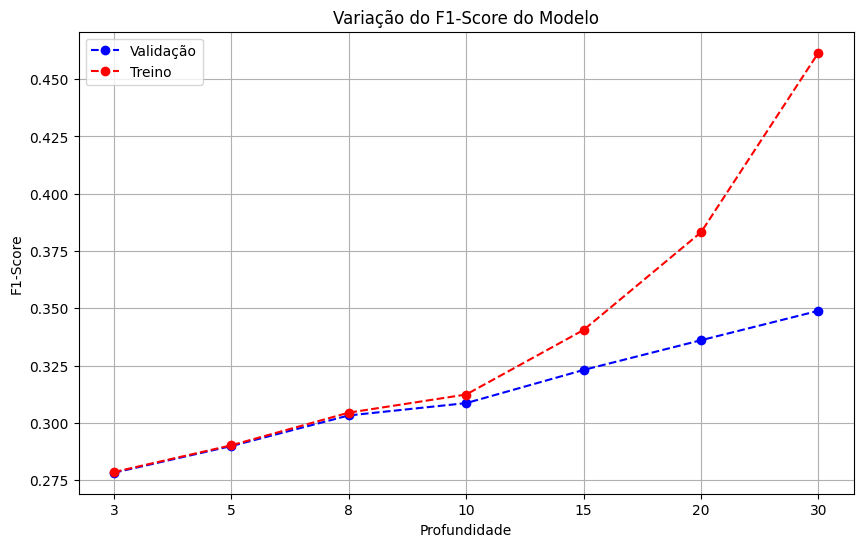

In [20]:
import matplotlib.pyplot as plt

max_depths_labels = [str(d) if d is not None else '-' for d in max_depths]

plt.figure(figsize=(10,6))
plt.plot(max_depths_labels, f1_scores_valid, marker='o', linestyle='--', color='b', label='Validação')
plt.plot(max_depths_labels, f1_scores_train, marker='o', linestyle='--', color='r', label='Treino')
plt.title('Variação do F1-Score do Modelo')
plt.xlabel('Profundidade')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
import numpy as np

X_train2 = np.concatenate((X_train, X_valid), axis=0)
y_train2 = np.concatenate((y_train, y_valid), axis=0)

class_counts = Counter(y_train2)

under_sampler_final = RandomUnderSampler(
    sampling_strategy={0: class_counts[1]},
    random_state=42
)
over_sampler_final = SMOTE(
    sampling_strategy={2: class_counts[1] // 2},
    random_state=42
)
pipeline_final = Pipeline([
    ('under', under_sampler_final),
    ('over', over_sampler_final)
])

X_train_final, y_train_final = pipeline_final.fit_resample(X_train2, y_train2)

# best_max_depth = max_depths[np.argmax(f1_scores_valid)]

# print(f"Best max_depth: {best_max_depth}")

best_max_depth = 50

dt = RandomForestClassifier(max_depth=best_max_depth, class_weight='balanced', random_state=0)
dt.fit(X_train_final, y_train_final)

y_pred = dt.predict(X_test)
# acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
# print(f"Accuracy: {acc:.3f}")
print(f"F1-macro: {f1:.3f}")

/home/gabriel/Documents/UFRGS/2025-2/ML/TF/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


F1-macro: 0.920


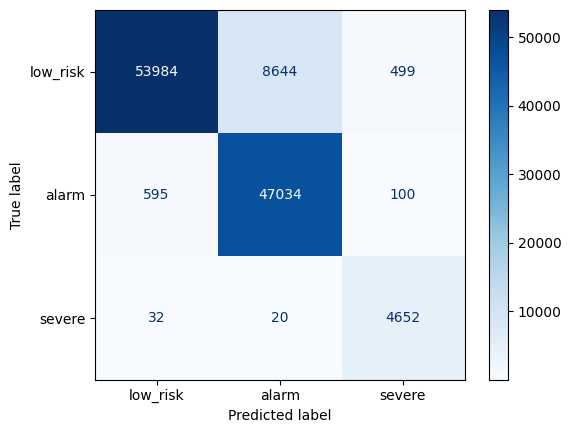

In [14]:
# Plota a matriz de confusão
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=target_names, cmap=plt.cm.Blues)

### Abordagem Alternativa: Hierarquia de Classificadores
Decompõe o problema original (multi-classe) em um hierarquia de problemas de classificação binária.

In [23]:
# Primeiro classificador: classifica entre 'low_risk' e 'high_risk' ('alarm' ou 'severe')
X_c1_train = X_train
X_c1_valid = X_valid
X_c1_test = X_test

target_mapping_c1 = {
    target_mapping[name]: int(name != "low_risk") for name in target_names
}
y_c1_train = y_train.map(target_mapping_c1)
y_c1_valid = y_valid.map(target_mapping_c1)
y_c1_test = y_test.map(target_mapping_c1)

target_names_c1 = ["low_risk", "high_risk"]

print(X_c1_train.shape)
print(X_c1_test.shape)
print(X_c1_valid.shape)

(1128680, 42)
(241861, 42)
(241861, 42)


In [24]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Distribuição original do treino:", Counter(y_c1_train))

under_sampler = RandomUnderSampler(
    sampling_strategy={0: 200000},
    random_state=42
)
over_sampler = SMOTE(
    sampling_strategy=1.0,
    random_state=42
)
pipeline = Pipeline([
    ('under', under_sampler),
    ('over', over_sampler)
])

X_c1_train_resampled, y_c1_train_resampled = pipeline.fit_resample(X_c1_train, y_c1_train)

print("Distribuição do treino após amostragem:", Counter(y_c1_train_resampled))

Distribuição original do treino: Counter({0: 1111644, 1: 17036})
Distribuição do treino após amostragem: Counter({0: 200000, 1: 200000})


In [25]:
from sklearn.metrics import recall_score

max_depths = [3, 5, 8, 10, 15, 20, 30]
min_samples_leaf_values = [1, 5, 10, 15, 20, 50, 100]

# recall_values = []
max_recall = -1
best_max_depth = None
best_min_samples_leaf = None

for depth in max_depths:
    for min_samples_leaf in min_samples_leaf_values:
        dt = RandomForestClassifier(
            max_depth=depth, min_samples_leaf=min_samples_leaf, class_weight='balanced', random_state=0
        )
        dt.fit(X_c1_train, y_c1_train)

        y_pred = dt.predict(X_c1_valid)

        recall = recall_score(y_c1_valid, y_pred)
        # recall_values.append(recall)

        print(f"Config ({depth}, {min_samples_leaf}): Recall = {recall}")

        if recall > max_recall:
            best_max_depth = depth
            best_min_samples_leaf = min_samples_leaf


Config (3, 1): Recall = 0.6357162421254451
Config (3, 5): Recall = 0.6357162421254451
Config (3, 10): Recall = 0.6357162421254451
Config (3, 15): Recall = 0.6357162421254451
Config (3, 20): Recall = 0.6357162421254451
Config (3, 50): Recall = 0.6357162421254451
Config (3, 100): Recall = 0.6357162421254451
Config (5, 1): Recall = 0.6009312517118598


KeyboardInterrupt: 

In [26]:
from sklearn.metrics import classification_report
import numpy as np

X_c1_train_full = np.concatenate((X_c1_train, X_c1_valid), axis=0)
y_c1_train_full = np.concatenate((y_c1_train, y_c1_valid), axis=0)

under_sampler_final = RandomUnderSampler(
    sampling_strategy={0: 200000},
    random_state=42
)
over_sampler_final = SMOTE(
    sampling_strategy=1.0,
    random_state=42
)
pipeline_final = Pipeline([
    ('under', under_sampler_final),
    ('over', over_sampler_final)
])

X_c1_train_final, y_c1_train_final = pipeline_final.fit_resample(X_c1_train_full, y_c1_train_full)

# print(f"Best max_depth: {best_max_depth}, Best min_samples_leaf: {best_min_samples_leaf}")

best_max_depth = 10
best_min_samples_leaf = 100

dt_c1 = RandomForestClassifier(
    max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, class_weight='balanced', random_state=0
)
dt_c1.fit(X_c1_train_final, y_c1_train_final)

y_pred = dt_c1.predict(X_c1_test)

report = classification_report(y_c1_test, y_pred, target_names=target_names_c1)
print(report)

/home/gabriel/Documents/UFRGS/2025-2/ML/TF/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

    low_risk       0.99      0.86      0.92    238211
   high_risk       0.05      0.53      0.10      3650

    accuracy                           0.85    241861
   macro avg       0.52      0.69      0.51    241861
weighted avg       0.98      0.85      0.91    241861



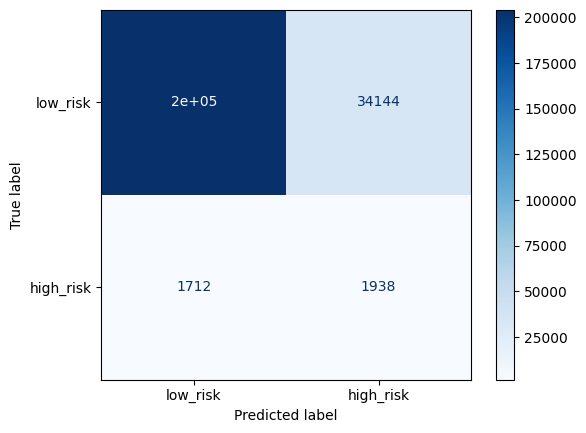

In [27]:
# Plota a matriz de confusão
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_c1_test, y_pred, display_labels=target_names_c1, cmap=plt.cm.Blues)

In [28]:
# Segundo classificador: classifica entre 'alarm' e 'severe'
df_train = X_train
df_valid = X_valid
df_test = X_test

df_train["severity"] = y_train
df_valid["severity"] = y_valid
df_test["severity"] = y_test

df_train = df_train[df_train["severity"].isin([1, 2])]
df_valid = df_valid[df_valid["severity"].isin([1, 2])]
df_test = df_test[df_test["severity"].isin([1, 2])]

X_c2_train = df_train.drop("severity", axis=1)
X_c2_valid = df_valid.drop("severity", axis=1)
X_c2_test = df_test.drop("severity", axis=1)

y_c2_train = df_train["severity"]
y_c2_valid = df_valid["severity"]
y_c2_test = df_test["severity"]

target_mapping_c2 = {1: 0, 2: 1}
y_c2_train = y_c2_train.map(target_mapping_c2)
y_c2_valid = y_c2_valid.map(target_mapping_c2)
y_c2_test = y_c2_test.map(target_mapping_c2)

target_names_c2 = ["alarm", "severe"]

print(X_c2_train.shape)
print(X_c2_test.shape)
print(X_c2_valid.shape)

(17036, 42)
(3650, 42)
(3651, 42)


In [29]:
from imblearn.combine import SMOTETomek
from collections import Counter

print("Distribuição original do treino:", Counter(y_c2_train))

over_sampler = SMOTETomek(
    sampling_strategy=1.0,
    random_state=42
)

X_c2_train_resampled, y_c2_train_resampled = over_sampler.fit_resample(X_c2_train, y_c2_train)

print("Distribuição do treino após amostragem:", Counter(y_c2_train_resampled))

Distribuição original do treino: Counter({0: 15443, 1: 1593})
Distribuição do treino após amostragem: Counter({1: 15387, 0: 15387})


In [ ]:
from sklearn.metrics import recall_score

max_depths = [5, 8, 10, 15, 20, 25, 30, 50, 75, 100, None]
min_samples_leaf_values = [1, 2, 5, 8, 10, 12, 15, 20, 25]

# recall_values = []
max_recall = -1
best_max_depth = None
best_min_samples_leaf = None

for depth in max_depths:
    for min_samples_leaf in min_samples_leaf_values:
        dt = RandomForestClassifier(
            max_depth=depth, min_samples_leaf=min_samples_leaf, class_weight='balanced', random_state=0
        )
        dt.fit(X_c2_train, y_c2_train)

        y_pred = dt.predict(X_c2_valid)

        recall = recall_score(y_c2_valid, y_pred)
        # recall_values.append(recall)

        print(f"Config ({depth}, {min_samples_leaf}): Recall = {recall}")

        if recall > max_recall:
            best_max_depth = depth
            best_min_samples_leaf = min_samples_leaf


Config (5, 1): Recall = 0.6695906432748538
Config (5, 2): Recall = 0.6695906432748538
Config (5, 5): Recall = 0.6695906432748538
Config (5, 8): Recall = 0.672514619883041
Config (5, 10): Recall = 0.672514619883041
Config (5, 12): Recall = 0.6754385964912281
Config (5, 15): Recall = 0.6754385964912281
Config (5, 20): Recall = 0.6812865497076024
Config (5, 25): Recall = 0.6783625730994152
Config (8, 1): Recall = 0.6549707602339181
Config (8, 2): Recall = 0.6549707602339181
Config (8, 5): Recall = 0.6491228070175439
Config (8, 8): Recall = 0.6461988304093568
Config (8, 10): Recall = 0.6432748538011696
Config (8, 12): Recall = 0.6461988304093568
Config (8, 15): Recall = 0.652046783625731
Config (8, 20): Recall = 0.6491228070175439
Config (8, 25): Recall = 0.6461988304093568
Config (10, 1): Recall = 0.5409356725146199
Config (10, 2): Recall = 0.5467836257309941
Config (10, 5): Recall = 0.5467836257309941
Config (10, 8): Recall = 0.5760233918128655
Config (10, 10): Recall = 0.564327485380117

In [30]:
from sklearn.metrics import classification_report
from imblearn.combine import SMOTETomek

X_c2_train_full = np.concatenate((X_c2_train, X_c2_valid), axis=0)
y_c2_train_full = np.concatenate((y_c2_train, y_c2_valid), axis=0)

over_sampler_final = SMOTETomek(
    sampling_strategy=1.0,
    random_state=42
)

X_c2_train_final, y_c2_train_final = over_sampler_final.fit_resample(X_c2_train_full, y_c2_train_full)

# print(f"Best max_depth: {best_max_depth}, Best min_samples_leaf: {best_min_samples_leaf}")

best_max_depth = 5
best_min_samples_leaf = 20

dt_c2 = RandomForestClassifier(
    max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, class_weight='balanced', random_state=0
)
dt_c2.fit(X_c2_train_final, y_c2_train_final)

y_pred = dt_c2.predict(X_c2_test)

report = classification_report(y_c2_test, y_pred, target_names=target_names_c2)
print(report)

              precision    recall  f1-score   support

       alarm       0.94      0.83      0.88      3309
      severe       0.22      0.46      0.30       341

    accuracy                           0.80      3650
   macro avg       0.58      0.65      0.59      3650
weighted avg       0.87      0.80      0.83      3650



/home/gabriel/Documents/UFRGS/2025-2/ML/TF/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


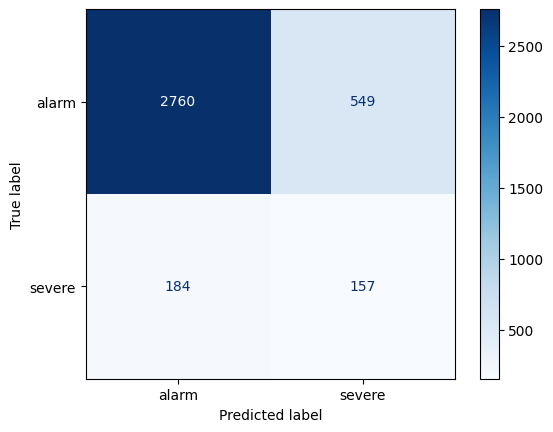

In [31]:
# Plota a matriz de confusão
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_c2_test, y_pred, display_labels=target_names_c2, cmap=plt.cm.Blues)

/home/gabriel/Documents/UFRGS/2025-2/ML/TF/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/gabriel/Documents/UFRGS/2025-2/ML/TF/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


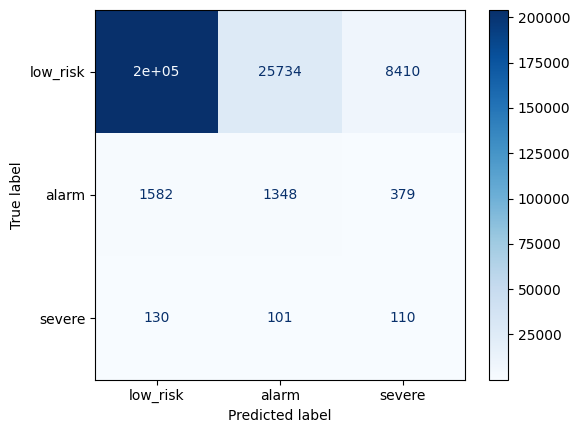

In [32]:
X_test = X_test.drop("severity", axis=1)

y_pred_c1 = dt_c1.predict(X_test)

low_risk_indices = (y_pred_c1 == 0)
high_risk_indices = (y_pred_c1 == 1)

# Filtra os exemplos classificados como 'high_risk'
X_test_high_risk = X_test[high_risk_indices]
y_test_high_risk = y_test[high_risk_indices]

y_pred_c2 = dt_c2.predict(X_test_high_risk)

# Plota a matriz de confusão combinada
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Combina as previsões dos dois classificadores
y_pred_combined = np.zeros_like(y_pred_c1)
y_pred_combined[low_risk_indices] = 0  # 'low_risk' é mapeado para 0
y_pred_combined[high_risk_indices] = y_pred_c2 + 1  # 'alarm' é 1 e 'severe' é 2
target_names_combined = ["low_risk", "alarm", "severe"]

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_combined, display_labels=target_names_combined, cmap=plt.cm.Blues)

In [33]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_combined, target_names=target_names_combined)
print(report)

              precision    recall  f1-score   support

    low_risk       0.99      0.86      0.92    238211
       alarm       0.05      0.41      0.09      3309
      severe       0.01      0.32      0.02       341

    accuracy                           0.85    241861
   macro avg       0.35      0.53      0.34    241861
weighted avg       0.98      0.85      0.91    241861

